In [1]:
import requests
import csv
from bs4 import BeautifulSoup as bs
import pandas as pd
from pymystem3 import Mystem
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
header = {'Accept': '*/*', 
              'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1 Safari/605.1.15'}


In [3]:
#вставить ссылку с поискового запроса на hh
base_url = 'https://hh.ru/search/vacancy?area=1&clusters=true&enable_snippets=true&text=python+analyst&specialization=1.25&from=cluster_specialization&showClusters=true'

In [4]:
pagination_url = base_url + '&page'

In [5]:
pagination_url

'https://hh.ru/search/vacancy?area=1&clusters=true&enable_snippets=true&text=python+analyst&specialization=1.25&from=cluster_specialization&showClusters=true&page'

In [6]:
urls = []
set_of_links = set()
session = requests.Session()
big_dict = dict()
big_dict_requirments = dict()
dict_experience = dict()
employment_dict = dict()
request_ = session.get(base_url, headers=header)


In [7]:
if request_.status_code == 200:
    
    soup = bs(request_.content, 'lxml')

else:
    print('error from hh.ru response')

In [8]:
try:
    pagination = soup.find_all('a', attrs={'data-qa': 'pager-page'})
    number_of_pages = int(pagination[-1].text)
    for i in range(number_of_pages + 1):
        url = f'{pagination_url}={i}'
        if url not in urls:
            urls.append(url)
except:
    print(request.status_code)

In [9]:
number_of_pages

10

In [10]:
# получаем множество ссылок на вакансии set_of_links 
# и создаем словарь big_dict с ключем ссылка на вакансию и значением списком компания и должность
for url in urls:
    request = session.get(url, headers=header)
    soup = bs(request.content, 'lxml')
    divs = soup.find_all('div', attrs={'data-qa': 'vacancy-serp__vacancy'})
    for div in divs:
        title = div.find('a', attrs={'data-qa': 'vacancy-serp__vacancy-title'}).text
        href = div.find('a', attrs={'data-qa': 'vacancy-serp__vacancy-title'})['href']
        try:
            company = div.find('a', attrs={'data-qa': 'vacancy-serp__vacancy-employer'}).text
        except:
            company = div.find('div', 'vacancy-serp-item__meta-info').text
        big_dict[href] = [company, title]
        set_of_links.add(href)

In [11]:
#Количество вакансий 
len(set_of_links)

470

In [12]:
# !!! ATTENTION для 20 страниц поисковой выдачи выполнение может занимать до 5 минут!! 

#составляем словарь big_dict_requirments ключевых навыков для каждой вакансии,
#если в вакансии не указан ключевые навыки, то заполняем пустой строкой

for vacancy_link in set_of_links:
    key_skills_list = []
    request = session.get(vacancy_link, headers=header)
    soup = bs(request.content, 'lxml')

    description = soup.find('div', attrs={'class': 'vacancy-description'})
    
    for row in description:
        key_skills = description.find_all('span', attrs={'data-qa': 'bloko-tag__text'})
        
    for key_skill in key_skills:
        key_skills_list.append(key_skill.text)
        
    if key_skills_list != []:
        big_dict_requirments[vacancy_link] = [key_skills_list]
    else:
        big_dict_requirments[vacancy_link] = ''
    
    experience = soup.find('span', attrs={'data-qa': 'vacancy-experience'}).text
    employment = soup.find('p', attrs={'data-qa': 'vacancy-view-employment-mode'}).text
        
    dict_experience[vacancy_link] = experience
    employment_dict[vacancy_link] = employment

In [14]:
#создаем df с колонками: 1) ссылка на вакансию(уникальный ключ/индекс таблицы), 2) компанией и 3) названием должности/позиции
general_df = pd.DataFrame.from_dict(data=big_dict, columns=['company', 'title'], orient='index').reset_index()
general_df = general_df.rename(columns={'index':'link'})

#создаем df с колонками: 1) ссылка на вакансию(уникальный ключ), 2) список ключевых навыков
description_df = pd.DataFrame.from_dict(data=big_dict_requirments, columns=['key_skills'], orient='index').reset_index()
description_df = description_df.rename(columns={'index':'link'})

experince_df = pd.DataFrame.from_dict(data=dict_experience, columns=['experience'], orient='index').reset_index()
experince_df = experince_df.rename(columns={'index':'link'})

employment_df = pd.DataFrame.from_dict(data=employment_dict, columns=['employment'], orient='index').reset_index()
employment_df = employment_df.rename(columns={'index':'link'})

#объединяем два df по ключу ссылка
total_df = general_df.merge(description_df, on='link')
total_df = total_df.merge(experince_df, on='link')
total_df = total_df.merge(employment_df, on='link')

In [50]:
emp_list = total_df['employment'].unique().tolist()

In [51]:
emp_list

['Полная занятость, полный день',
 'Полная занятость, гибкий график',
 'Стажировка, полный день',
 'Частичная занятость, полный день',
 'Полная занятость, удаленная работа',
 'Частичная занятость, гибкий график',
 'Стажировка, гибкий график']

In [52]:
def emp_adj(df):
    emp_type = df['employment']
    if 'Стажировка' in emp_type:
        return 'Стажировка'
    if 'удаленная' in emp_type or 'Удаленная' in emp_type:
        return 'Удаленная работа'
    return 'Полная занятость'

In [53]:
total_df['employment_agg'] = total_df.apply(emp_adj, axis=1)

In [15]:
total_df.head()

,link,company,title,key_skills,experience,employment
0,https://hh.ru/vacancy/34533419?query=python%20...,ManyChat,Intern/Junior Data Analyst,"[Математическая статистика, MS SQL, R, Python,...",не требуется,"Полная занятость, полный день"
1,https://hh.ru/vacancy/31648507?query=python%20...,ManyChat,Senior Product / Data Analyst,"[Анализ бизнес показателей, Анализ временных р...",3–6 лет,"Полная занятость, полный день"
2,https://hh.ru/vacancy/36024461?query=python%20...,ООО НТС,Аналитик данных,"[SQL, Python, Data Mining, Data Analysis, Анал...",не требуется,"Полная занятость, полный день"
3,https://hh.ru/vacancy/35945229?query=python%20...,Ремонтиста,Аналитик данных,"[Python, Математическое моделирование, Управле...",3–6 лет,"Полная занятость, полный день"
4,https://hh.ru/vacancy/36024905?query=python%20...,ДомКлик,Аналитик данных,"[SQL, Аналитические исследования, Статистическ...",1–3 года,"Полная занятость, полный день"


In [16]:
#топ-15 названий вакансий по частоте
total_df['title'].value_counts().to_frame().head(15)

,title
Аналитик данных,21
Аналитик,20
Аналитик BI,8
Продуктовый аналитик,8
Системный аналитик,7
Data Scientist,6
Бизнес-аналитик,5
Аналитик данных (data scientist),3
Data Engineer,3
Продуктовый Аналитик,3


In [17]:
def company_agg(df):
    company = df['company']
    
    if 'OZON' in company:
        return 'OZON'
    elif 'Mail.Ru' in company:
        return 'Mail.Ru'
    elif 'Сбербанк' in company:
        return 'Sberbank'
    else:
        return company
    

In [18]:
total_df['company_adj'] = total_df.apply(company_agg, axis=1)

In [19]:
#топ-15 компаний по количеству вакансий
total_df['company_adj'].value_counts().to_frame().head(15)

,company_adj
Mail.Ru,17
Skyeng,13
Sberbank,12
Банк ВТБ (ПАО),11
Яндекс,11
OZON,11
Тинькофф,10
Авито,7
Tele2,7
АО Газпромбанк,6


In [20]:
#считаем количество вакансий, где не заполнены ключевые навыки
total_df[total_df['key_skills'] == ''].count()

link           0
company        0
title          0
key_skills     0
experience     0
employment     0
company_adj    0
dtype: int64

In [21]:
#считаем долю вакансий, где не заполнены ключевые навыки
total_df[total_df['key_skills'] == ''].count() / total_df.count()

link           0.0
company        0.0
title          0.0
key_skills     0.0
experience     0.0
employment     0.0
company_adj    0.0
dtype: float64

In [22]:
#топ - 10 компаний, которые не заполнили ключевые навыки в вакансии, отсортированные по количеству вакансий
total_df[total_df['key_skills']== ''].groupby('company').agg({'title':'count'})\
    .sort_values(by='title', ascending=False).head(10)

,title
company,


In [23]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470 entries, 0 to 469
Data columns (total 7 columns):
link           470 non-null object
company        470 non-null object
title          470 non-null object
key_skills     360 non-null object
experience     470 non-null object
employment     470 non-null object
company_adj    470 non-null object
dtypes: object(7)
memory usage: 29.4+ KB


In [34]:
#функция возвращает словарь, в котором считаем частоту ключвых навыков, по колонке 'key_skills' в df
def words_counter_df(df):
    merged = dict()
    for row in df['key_skills']:
        if row is None:
            pass
        else:
            for word in row:
                if word in merged:
                    merged[word] += 1
                else:
                    merged[word] = 1
    counter_dict = {k: v for k, v in sorted(merged.items(), key=lambda item: item[1], reverse=True)}
    skills_df = pd.DataFrame.from_dict(data=counter_dict, columns=['skill'], orient='index').reset_index()
    skills_df = skills_df.rename(columns={'index':'skill_', 'skill': 'count'})
    return skills_df

In [31]:
exp_list = total_df['experience'].unique().tolist()

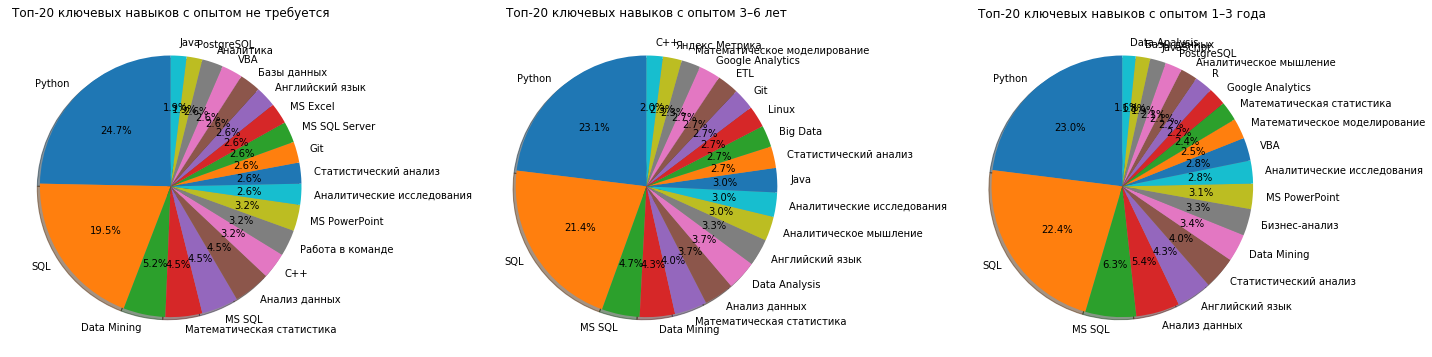

In [42]:
fig, axs = plt.subplots(1,3,figsize=(20,10), facecolor='w', edgecolor='k')

for ax, exp in zip(axs.flat, exp_list):
    filtered_df = total_df[total_df['experience'] == exp]
    skills_df = words_counter_df(filtered_df)
    ax.pie(skills_df.head(20)['count'], labels=skills_df.head(20)['skill_'], autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax.set_title("Топ-20 ключевых навыков с опытом {}".format(exp))
fig.tight_layout()
plt.show()

In [54]:
emp_list = total_df['employment_agg'].unique().tolist()

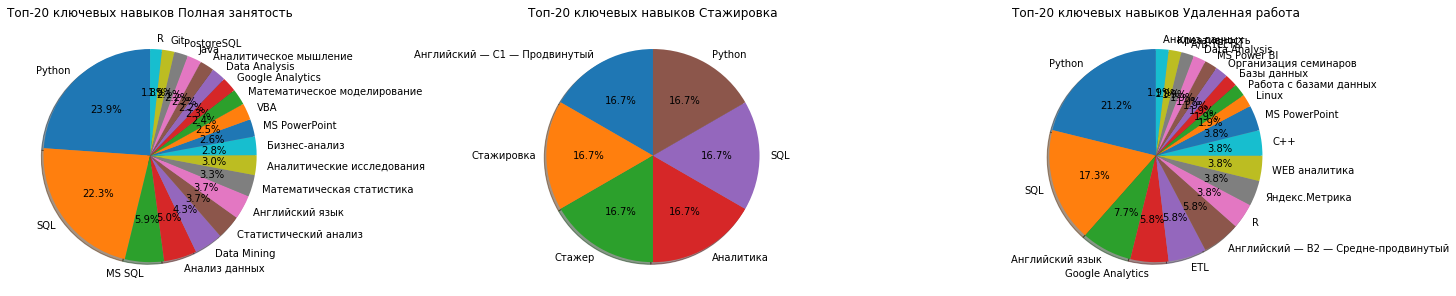

In [58]:
fig, axs = plt.subplots(1,3,figsize=(20,20), facecolor='w', edgecolor='k')

for ax, emp in zip(axs.flat, emp_list):
    filtered_df = total_df[total_df['employment_agg'] == emp]
    skills_df = words_counter_df(filtered_df)
    ax.pie(skills_df.head(20)['count'], labels=skills_df.head(20)['skill_'], autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax.set_title("Топ-20 ключевых навыков {}".format(emp))
fig.tight_layout()
plt.show()

In [57]:
total_df[total_df['employment_agg'] == 'Стажировка']

,link,company,title,key_skills,experience,employment,company_adj,employment_agg
51,https://hh.ru/vacancy/35979261?query=python%20...,Авито,Стажер в отдел Data science,None,не требуется,"Стажировка, полный день",Авито,Стажировка
378,https://hh.ru/vacancy/35836629?query=python%20...,OZON.ru интернет-витрина,Стажер / Бизнес-аналитик,"[Английский — C1 — Продвинутый, Стажировка, Ст...",не требуется,"Стажировка, гибкий график",OZON,Стажировка
401,https://hh.ru/vacancy/35789731?query=python%20...,ANCOR FinTech,Cтажер data-аналитик,None,не требуется,"Стажировка, полный день",ANCOR FinTech,Стажировка


In [59]:
total_df[total_df['employment_agg'] == 'Удаленная работа']

,link,company,title,key_skills,experience,employment,company_adj,employment_agg
116,https://hh.ru/vacancy/34636849?query=python%20...,ЦЕНТРОФИНАНС,Аналитик данных,"[Python, Linux, Работа с базами данных, Базы д...",1–3 года,"Полная занятость, удаленная работа",ЦЕНТРОФИНАНС,Удаленная работа
145,https://hh.ru/vacancy/35938249?query=python%20...,ИП Попов Михаил Эдуардович,Аналитик BI,"[Английский язык, Google Analytics, MS Power BI]",1–3 года,"Полная занятость, удаленная работа",ИП Попов Михаил Эдуардович,Удаленная работа
164,https://hh.ru/vacancy/35661239?query=python%20...,Ruby Labs Ltd,Senior Data Analyst,"[Data Analysis, SQL, R, Python, A/B тесты]",3–6 лет,"Полная занятость, удаленная работа",Ruby Labs Ltd,Удаленная работа
171,https://hh.ru/vacancy/35829664?query=python%20...,ООО Трастид Т,"Product manager (SaaS, Eng)",None,1–3 года,"Полная занятость, удаленная работа",ООО Трастид Т,Удаленная работа
195,https://hh.ru/vacancy/36056311?query=python%20...,"Издательство МАНН, ИВАНОВ и ФЕРБЕР",Бизнес-аналитик интернет-магазина,"[Python, Креативность, Яндекс.Метрика, Google ...",3–6 лет,"Полная занятость, удаленная работа","Издательство МАНН, ИВАНОВ и ФЕРБЕР",Удаленная работа
218,https://hh.ru/vacancy/36017827?query=python%20...,Skyeng,Data analyst (Customer Service),"[Python, MS SQL, SQL, ETL]",3–6 лет,"Полная занятость, удаленная работа",Skyeng,Удаленная работа
224,https://hh.ru/vacancy/36017863?query=python%20...,Skyeng,Senior Product analyst,"[SQL, Business Intelligence Systems, Python]",3–6 лет,"Полная занятость, удаленная работа",Skyeng,Удаленная работа
324,https://hh.ru/vacancy/35930734?query=python%20...,ООО Технологии в образовании,Исследователь-аналитик в Quality Lab онлайн-шк...,"[Английский — B2 — Средне-продвинутый, Python,...",1–3 года,"Полная занятость, удаленная работа",ООО Технологии в образовании,Удаленная работа
325,https://hh.ru/vacancy/35930718?query=python%20...,ООО Технологии в образовании,Исследователь-аналитик в Quality Lab онлайн-шк...,"[Английский — B2 — Средне-продвинутый, Python,...",1–3 года,"Полная занятость, удаленная работа",ООО Технологии в образовании,Удаленная работа
333,https://hh.ru/vacancy/35930677?query=python%20...,ООО Технологии в образовании,Старший исследователь-аналитик в Quality Lab о...,"[Python, SQL, Английский язык, VBA, C++]",3–6 лет,"Полная занятость, удаленная работа",ООО Технологии в образовании,Удаленная работа
